## Homework 5 可解释模型

In [22]:
import torch
import torch.nn as nn 
import os
import numpy as np 
import re

In [13]:
# ------------------------------- 基本变量 ---------------------------------
checkpoint_path = "./hw3.pkl"
train_data_path = "/home/qiyunfei/code/homework/data/"
pokemon_path = os.path.join(train_data_path,"pokemon")
digimon_path = os.path.join(train_data_path,"digimon")


In [135]:

# ------------------------------- 被解释模型定义 ---------------------------------

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding)
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # 64 * 128 * 128
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),  # 64 * 64 * 64

            nn.Conv2d(64, 128, 3, 1, 1),  # 128 * 64 * 64
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),   # 128 * 32 * 32

            nn.Conv2d(128, 256, 3, 1, 1),  # 256,32,32
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),    # 256, 16,16

            nn.Conv2d(256, 512, 3, 1, 1),  # 512,8,8
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),    # 512,8,8

            nn.Conv2d(512, 512, 3, 1, 1),  # 512,8,8
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0)  # 512, 4,4
        )
        self.fn = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.reshape(out.size()[0], -1)
        return self.fn(out)


In [136]:

# ------------------------------- 加载模型 ---------------------------------
if torch.cuda.is_available():
    device = "cuda"
else:     
    device = "cpu"
model = Classifier()
model = model.to(device)
checkpoint = torch.load(checkpoint_path)
# 加载模型参数
model.load_state_dict(checkpoint)


<All keys matched successfully>

In [27]:
import torchvision.transforms as transforms
# ------------------------------- 定义数据集 ---------------------------------

# training 时做 data augmentation
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),  # 图片水平旋转
    transforms.RandomRotation(15),  # 随机旋转图片
    transforms.ToTensor()  # 图片转Tensor，并惊醒归一化
])

# testing 时不需要要做 data augmentation
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

from torch.utils.data import Dataset
class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None) -> None:
        super().__init__()
        self.x = x
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X
            
    def getbatch(self, indices):
        images = []
        labels = []
        for index in indices:
          image, label = self.__getitem__(index)
          images.append(image)
          labels.append(label)
        return torch.stack(images), torch.tensor(labels)


import cv2

train_size = 500
val_size = 200
test_size = 100
def readfile(path, label=None):
    images_dir = sorted(os.listdir(path))
    d_size = train_size+test_size+val_size
    x = np.zeros((d_size, 128, 128, 3), dtype=np.uint8)
    if label is None:
        y = None
    else:
        y = np.zeros((d_size), dtype=np.uint8)
    for idx in range(d_size):
        file = images_dir[idx]
        if len(re.findall(r"\\.gif$", file)) > 0:
            continue
        p_file = os.path.join(path, file)
        p_file = p_file.replace('\\', '/')
        print(p_file)
        img = cv2.imread(p_file)
        x[idx, :, :] = cv2.resize(img, (128, 128))
        if y is not None:
            y[idx] = label

    if y is None:
        return x
    else:
        return x, y

## 指定待分析数据

In [30]:
x_p,y_p = readfile(pokemon_path, 1)
x_d,y_d = readfile(digimon_path, 0)
pokemon_set = ImgDataset(x_p,y_p,test_transform)
digimon_set = ImgDataset(x_d,y_d,test_transform)

/home/qiyunfei/code/homework/data/pokemon/abomasnow.png
/home/qiyunfei/code/homework/data/pokemon/abra.png
/home/qiyunfei/code/homework/data/pokemon/absol.png
/home/qiyunfei/code/homework/data/pokemon/accelgor.png
/home/qiyunfei/code/homework/data/pokemon/aegislash-blade.png
/home/qiyunfei/code/homework/data/pokemon/aerodactyl.png
/home/qiyunfei/code/homework/data/pokemon/aggron.png
/home/qiyunfei/code/homework/data/pokemon/aipom.png
/home/qiyunfei/code/homework/data/pokemon/alakazam.png
/home/qiyunfei/code/homework/data/pokemon/alomomola.png
/home/qiyunfei/code/homework/data/pokemon/altaria.png
/home/qiyunfei/code/homework/data/pokemon/amaura.png
/home/qiyunfei/code/homework/data/pokemon/ambipom.png
/home/qiyunfei/code/homework/data/pokemon/amoonguss.png
/home/qiyunfei/code/homework/data/pokemon/ampharos.png
/home/qiyunfei/code/homework/data/pokemon/anorith.png
/home/qiyunfei/code/homework/data/pokemon/araquanid.jpg
/home/qiyunfei/code/homework/data/pokemon/arbok.png
/home/qiyunfei/co

/home/qiyunfei/code/homework/data/pokemon/pyroar.png
/home/qiyunfei/code/homework/data/pokemon/pyukumuku.jpg
/home/qiyunfei/code/homework/data/pokemon/quagsire.png
/home/qiyunfei/code/homework/data/pokemon/quilava.png
/home/qiyunfei/code/homework/data/pokemon/quilladin.png
/home/qiyunfei/code/homework/data/pokemon/qwilfish.png
/home/qiyunfei/code/homework/data/pokemon/raichu.png
/home/qiyunfei/code/homework/data/pokemon/raikou.png
/home/qiyunfei/code/homework/data/pokemon/ralts.png
/home/qiyunfei/code/homework/data/pokemon/rampardos.png
/home/qiyunfei/code/homework/data/pokemon/rapidash.png
/home/qiyunfei/code/homework/data/pokemon/raticate.png
/home/qiyunfei/code/homework/data/pokemon/rattata.png
/home/qiyunfei/code/homework/data/pokemon/rayquaza.png
/home/qiyunfei/code/homework/data/pokemon/regice.png
/home/qiyunfei/code/homework/data/pokemon/regigigas.png
/home/qiyunfei/code/homework/data/pokemon/regirock.png
/home/qiyunfei/code/homework/data/pokemon/registeel.png
/home/qiyunfei/cod

/home/qiyunfei/code/homework/data/digimon/120px-Depthmon.jpg
/home/qiyunfei/code/homework/data/digimon/120px-Destromon.png
/home/qiyunfei/code/homework/data/digimon/120px-Deusmon.jpg
/home/qiyunfei/code/homework/data/digimon/120px-Devidramon.jpg
/home/qiyunfei/code/homework/data/digimon/120px-Devimon.jpg
/home/qiyunfei/code/homework/data/digimon/120px-Devitamamon.jpg
/home/qiyunfei/code/homework/data/digimon/120px-Dezipmon.jpg
/home/qiyunfei/code/homework/data/digimon/120px-Diablomon.jpg
/home/qiyunfei/code/homework/data/digimon/120px-Dinobeemon.jpg
/home/qiyunfei/code/homework/data/digimon/120px-Dinohumon.jpg
/home/qiyunfei/code/homework/data/digimon/120px-Dinorexmon.jpg
/home/qiyunfei/code/homework/data/digimon/120px-Dinotigermon.jpg
/home/qiyunfei/code/homework/data/digimon/120px-Dobermon.jpg
/home/qiyunfei/code/homework/data/digimon/120px-Dobermon_x.jpg
/home/qiyunfei/code/homework/data/digimon/120px-Dorimon.jpg
/home/qiyunfei/code/homework/data/digimon/120px-Dorugamon.jpg
/home/qi

/home/qiyunfei/code/homework/data/digimon/120px-Saintgalgomon2.jpg
/home/qiyunfei/code/homework/data/digimon/120px-Sakumon.jpg
/home/qiyunfei/code/homework/data/digimon/120px-Sakusimon.jpg
/home/qiyunfei/code/homework/data/digimon/120px-Sakuttomon.jpg
/home/qiyunfei/code/homework/data/digimon/120px-Sakuyamon.jpg
/home/qiyunfei/code/homework/data/digimon/120px-Sakuyamon_miko.jpg
/home/qiyunfei/code/homework/data/digimon/120px-Salamandamon.jpg
/home/qiyunfei/code/homework/data/digimon/120px-Sandiramon.jpg
/home/qiyunfei/code/homework/data/digimon/120px-Sandyanmamon.jpg
/home/qiyunfei/code/homework/data/digimon/120px-Sangloupmon.jpg
/home/qiyunfei/code/homework/data/digimon/120px-Sanzomon.jpg
/home/qiyunfei/code/homework/data/digimon/120px-Sateramon.jpg
/home/qiyunfei/code/homework/data/digimon/120px-Savemon.jpg
/home/qiyunfei/code/homework/data/digimon/120px-Scopemon.jpg
/home/qiyunfei/code/homework/data/digimon/120px-Scorpiomon.jpg


In [78]:
img_indices = [60,90]
exp_pokemon = pokemon_set.getbatch(img_indices)
exp_digimon = digimon_set.getbatch(img_indices)
train_set = torch.cat((exp_pokemon[0],exp_digimon[0]),dim=0)
train_label = torch.cat((exp_pokemon[1],exp_digimon[1]))
print("Train set Size:{}".format(train_set.size()))
print("Label set Size:{}".format(train_label.size()))


Train set Size:torch.Size([4, 3, 128, 128])
Label set Size:torch.Size([4])


## Saliency Map

一般情况下，我们改变Model parameter 来拟合 image 与Label ，所以loss 在计算 backward时，我们只在乎loss 对 model parameter 的偏微分。

但是从数值上看，image 本身也是一个连续tensor，所以我们可以计算loss 对 input image的偏微分。这个偏微分表示，在model 和parameter 固定不变的情况下，改变image的某个像素 pixel value 会对loss 产生什么样的影响。

习惯上，把loss变化剧烈程度解释为当前pixel的重要度。

In [137]:
def normalize(image):
    return (image-image.min())/(image.max() - image.min())

def compute_saliency_maps(x,y,model):
    model.eval()
    X = x.to(device)
    Y = y.to(device)

    # 使得X具有梯度，因为我们要计算 loss 对 input部分的微分
    X.requires_grad_()

    Y_hat = model(X)
    loss_fn = torch.nn.CrossEntropyLoss()
    loss = loss_fn(Y_hat,Y)
    # 计算 loss 对 X 的偏微分
    loss.backward()

    salienies = X.grad.abs().detach().cpu()
    # 不同图片的Gradient 可能有很大落差，第一张图片Gradient 在100-10000 之间，而第二张图片Gradient 在0.001 - 0.01 之间，这就造成如果我们使用同样的色阶画图，第一张图片就会非常亮，而第二张图片非常暗。所以对每张saliency 做norma
    salienies = torch.stack([normalize(item) for item in salienies])
    return salienies

    

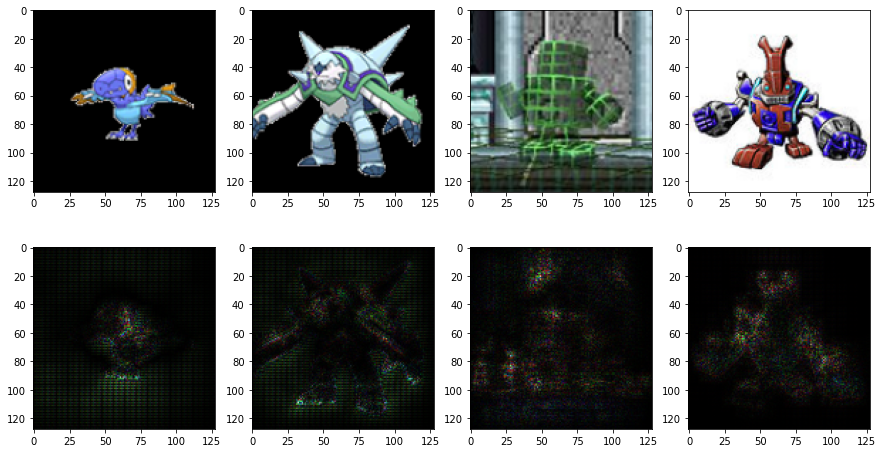

In [138]:
saliencies = compute_saliency_maps(train_set,train_label,model)

# 利用 matplatlib 绘图
import matplotlib.pylab as plt
ig, axs = plt.subplots(2, 4, figsize=(15, 8)) 
for row,target in enumerate([train_set,saliencies]):
    for column ,img in enumerate(target):
        axs[row][column].imshow(img.permute(1,2,0).numpy())
        # image tensor dimension是 channel,height,width
        # 而 matplatlib 需要的形状为：height,width,channels
plt.show()    


## Filter Explanation
如果想知道某个 filter 到底有什么作用，我们需要做两件事情
* Filter activation： 选几张图片，看看图片中有哪些位置会 activate 当前 filter
* Filter visualization: 怎样的图片，可以最大程度的 activate 当前  Filter

In [94]:
from torch.optim import Adam

layer_activations = None
def filter_explanation(x,model,cnn_id,filter_id,iteration = 100,lr = 0.1):
    # cnn_id,filter_id:用来指明需要查看那层 CNN 的 哪个 Filter
    model.eval()
    
    def hook(modek,input,output):
        global layer_activations
        layer_activations = output
    
    hook_handle = model.cnn[cnn_id].register_forward_hook(hook)
    # 告诉pytorch 当 forward 经过 filter_id 时，先呼叫hook后，才可以继续 forward

    X = x.to(device)
    model(X)

    filter_activations = layer_activations[:,filter_id,:,:].detach().cpu()

    # 找一张图片，可以最大程度Active Filter 
    X.requires_grad_()
    # 对X 求导
    optim = Adam([X],lr=lr)
    # 逐步更新X值，让Filter activate 值最大
    for item in range(iteration):
        optim.zero_grad()
        model(X)
        objective = -layer_activations[:, filter_id, :, :].sum()
        
        objective.backward()
        optim.step()
    filter_visualization = X.detach().cpu().squeeze()[0]
    
    # 非常重要，一旦对model 做了 register hook 则 hook 就会一直存在，如果之后继续resister,那么模型一次forward 做到事情就会非常多。
    hook_handle.remove()
    return filter_activations, filter_visualization

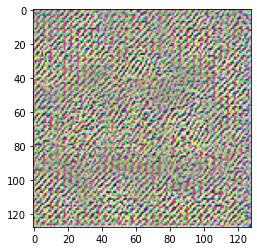

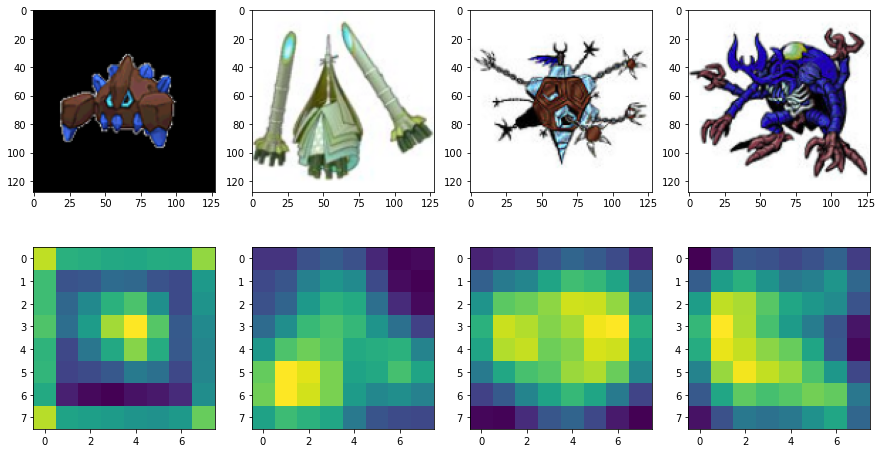

In [99]:
filter_activations, filter_visualization = filter_explanation(train_set,model,cnn_id =16,filter_id=0,iteration = 100,lr = 0.1)

# 展示 filter_visualization
plt.imshow(normalize(filter_visualization.permute(1, 2, 0)))
plt.show()

fig, axs = plt.subplots(2, 4, figsize=(15, 8))
for i, img in enumerate(train_set):
  axs[0][i].imshow(img.permute(1, 2, 0))
for i, img in enumerate(filter_activations):
  axs[1][i].imshow(normalize(img))
plt.show()

## Lime Explanation


In [140]:
from skimage.segmentation import slic

def predict(input):
    # input: (batches, height, width, channels)    
    model.eval()
    # batch channel height width
    input = torch.FloatTensor(input).permute(0,3,1,2)
    output = model(input.to(device))
    return output.detach().cpu().numpy()



def segmentation(input):
    # 利用 skimage 提供的 segmentation 将图片分成100分
    return slic(input,n_segments = 100,compactness=1,sigma=1)

Train set Size:torch.Size([4, 3, 128, 128])
Label set Size:torch.Size([4])


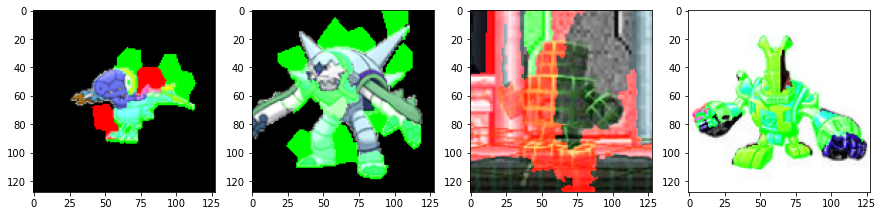

In [141]:
from lime import lime_image

img_indices = [20,100]
exp_pokemon = pokemon_set.getbatch(img_indices)
exp_digimon = digimon_set.getbatch(img_indices)
train_set = torch.cat((exp_pokemon[0],exp_digimon[0]),dim=0)
train_label = torch.cat((exp_pokemon[1],exp_digimon[1]))
print("Train set Size:{}".format(train_set.size()))
print("Label set Size:{}".format(train_label.size()))


fig, axs = plt.subplots(1, 4, figsize=(15, 8))                                                                                                                                                                 
np.random.seed(16)                                                                                                                                                       
# 讓實驗 reproducible
for idx, (image, label) in enumerate(zip(train_set.permute(0, 2, 3, 1).numpy(), train_label)):                                                                                                                                             
    x = image.astype(np.double)
    # lime 這個套件要吃 numpy array

    explainer = lime_image.LimeImageExplainer()                                                                                                                              
    explaination = explainer.explain_instance(image=x, classifier_fn=predict, segmentation_fn=segmentation)
    # 基本上只要提供給 lime explainer 兩個關鍵的 function，事情就結束了
    # classifier_fn 定義圖片如何經過 model 得到 prediction
    # segmentation_fn 定義如何把圖片做 segmentation

    lime_img, mask = explaination.get_image_and_mask(                                                                                                                         
                                label=label.item(),                                                                                                                           
                                positive_only=False,                                                                                                                         
                                hide_rest=False,                                                                                                                             
                                num_features=11,                                                                                                                              
                                min_weight=0.05                                                                                                                              
                            )
    # 把 explainer 解釋的結果轉成圖片
    
    axs[idx].imshow(lime_img)

plt.show()
# 從以下前三章圖可以看到，model 有認出食物的位置，並以該位置為主要的判斷依據
# 唯一例外是第四張圖，看起來 model 似乎比較喜歡直接去認「碗」的形狀，來判斷該圖中屬於 soup 這個 class
# 至於碗中的內容物被標成紅色，代表「單看碗中」的東西反而有礙辨認。
# 當 model 只看碗中黃色的一坨圓形，而沒看到「碗」時，可能就會覺得是其他黃色圓形的食物。